### Plot Percent replicating for Spheroid Aggregated data

In [19]:
import pandas as pd
import numpy as np
import os

# Pycytominer
from pycytominer import feature_select
from pycytominer import normalize

# Grit scores
import random

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set_style("white")
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42


# Set current working directory
print(os.getcwd())
os.chdir('/share/data/analyses/christa/colopaint3D/spher_colo52_v1/3_GritScores')
print(os.getcwd())

/share/data/analyses/christa/colopaint3D/spher_colo52_v1/3_GritScores
/share/data/analyses/christa/colopaint3D/spher_colo52_v1/3_GritScores


In [20]:
# Set
perturbation = 'Metadata_pert_name'
cmpd_conc = 'Metadata_conc_step' # Use the step here to compare the different concentrations
cmpd_short_name = 'Metadata_name'

# Set a random seed
rng = np.random.RandomState(123)


In [21]:
# Load some utilities from this repository: 

def percent_score(null_dist, corr_dist, how='right'):
    """
    Calculates the Percent replicating
    :param null_dist: Null distribution
    :param corr_dist: Correlation distribution
    :param how: "left", "right" or "both" for using the 5th percentile, 95th percentile or both thresholds
    :return: proportion of correlation distribution beyond the threshold
    From REF: https://github.com/carpenter-singh-lab/2023_Cimini_NatureProtocols/blob/main/notebooks/utils.py
    """
    if how == 'right':
        perc_95 = np.nanpercentile(null_dist, 95)
        above_threshold = corr_dist > perc_95
        return 100 * np.mean(above_threshold.astype(float)), perc_95
    if how == 'left':
        perc_5 = np.nanpercentile(null_dist, 5)
        below_threshold = corr_dist < perc_5
        return 100 * np.mean(below_threshold.astype(float)), perc_5
    if how == 'both':
        perc_95 = np.nanpercentile(null_dist, 95)
        above_threshold = corr_dist > perc_95
        perc_5 = np.nanpercentile(null_dist, 5)
        below_threshold = corr_dist < perc_5
        return 100 * (np.mean(above_threshold.astype(float)) + np.mean(below_threshold.astype(float))), perc_95, perc_5
    
def corr_between_replicates(df, group_by_feature):
    """
    Calculate the correlation between replicates
    From REF: https://github.com/carpenter-singh-lab/2023_Cimini_NatureProtocols/blob/main/notebooks/utils.py
    """
    replicate_corr = []
    replicate_grouped = df.groupby(group_by_feature)
    for name, group in replicate_grouped:
        group_features = get_featuredata(group)
        corr = np.corrcoef(group_features)
        if len(group_features) == 1:  # If there is only one replicate on a plate
            replicate_corr.append(np.nan)
        else:
            np.fill_diagonal(corr, np.nan)
            replicate_corr.append(np.nanmedian(corr))  # median replicate correlation
    return replicate_corr

def corr_between_non_replicates(df, n_samples, n_replicates, metadata_compound_name):
    """
    Null distribution between random "replicates".
    :param df: pandas.DataFrame
    :param n_samples: int
    :param n_replicates: int
    :param metadata_compound_name: Compound name feature
    :return: list-like of correlation values, with a  length of `n_samples`
    """
    df.reset_index(drop=True, inplace=True)
    null_corr = []
    random.seed(42)
    while len(null_corr) < n_samples:
        compounds = random.choices([_ for _ in range(len(df))], k=n_replicates)
        sample = df.loc[compounds].copy()
        if len(sample[metadata_compound_name].unique()) == n_replicates:
            sample_features = get_featuredata(sample)
            corr = np.corrcoef(sample_features)
            np.fill_diagonal(corr, np.nan)
            null_corr.append(np.nanmedian(corr))  # median replicate correlation
    return null_corr

def get_featuredata(df):
    """return dataframe of just featuredata columns"""
    return df[get_featurecols(df)]

def get_featurecols(df):
    """return a list of featuredata columns"""
    return [c for c in df.columns if not "Metadata" in c]

def list_features(df):
    # List features
    list_of_selected_features = list(df.columns.values)
    list_of_metadata = list(df.columns[df.columns.str.contains("Metadata_")])
    list_of_selected_features = list(set(list_of_selected_features) - set(list_of_metadata))
    
    return list_of_selected_features, list_of_metadata

def process_correlation_data(df, perturbation):
    data = get_featuredata(df).groupby(df[perturbation]).mean()
    correlations = corr_between_replicates(df, perturbation)
    corr_dist = pd.DataFrame({perturbation: data.index, 'corr': correlations})
    corr_dist[[cmpd_short_name, cmpd_conc]] = corr_dist[perturbation].str.split("_", expand=True)
    # corr_dist[cmpd_conc] = corr_dist[cmpd_conc].astype(float)
    return corr_dist

In [22]:
cell_line = 'HCT116'

In [23]:
# Load the parquet file into a pandas dataframe

# Format the file name
# file = '../1_FeaturesImages_meanstd/WellAggregates/HCT116_MedianAgg_meanstd.parquet' 
# file = '../1_FeaturesImages_meanstd_PerPlate/WellAggregates/HCT116_MedianAgg_meanstd.parquet' # standardized
# file = '../1_FeaturesImages_minmax/WellAggregates/HCT116_MedianAgg_meanstd.parquet' # standardized
# file= '../1_FeaturesImages_minmax_PerPlate/WellAggregates/HCT116_MedianAgg_meanstd.parquet'
# file = '../1_FeaturesImages_none/WellAggregates/HCT116_MedianAgg_meanstd.parquet'
# file = '../1_FeaturesImages_prototype_perSlice/WellAggregates/HCT116_MedianAgg_meanstd.parquet' # 



# # name = file.split('/')[-1].split('.')[0]
# name = file.split('.')[2]
# print(name)


# # Load the parquet file
# data = pd.read_parquet(file)

# # Load metadata (I am missing the concentrations)
# metadata = pd.read_csv('spher_colo52-metadata.csv')

In [24]:
# List all files in directory
# dir = '../1_FeaturesImages_meanstd/SingleSlice/'
# dir = '../1_FeaturesImages_meanstd_PerPlate/SingleSlice/'
# dir = '../1_FeaturesImages_minmax/SingleSlice/'
# dir = '../1_FeaturesImages_minmax_PerPlate/SingleSlice/'
# dir = '../1_FeaturesImages_none/SingleSlice/'
# dir = '../1_FeaturesImages_prototype_perSlice/SingleSlice/'

# dir = '../old_features/1_FeaturesImages_normalized/SingleSlice/'
# dir = '../old_features/1_FeaturesImages_ns/SingleSlice/'
# dir = '../1_FeaturesImages_meanstd/SingleSlice/'
# dir = '../1_FeaturesImages_meanstd_PerPlate/SingleSlice/'
# dir = '../1_FeaturesImages_minmax/SingleSlice/'
# dir = '../1_FeaturesImages_minmax_PerPlate/SingleSlice/'
dir = '../1_FeaturesImages_none/SingleSlice/'


files = os.listdir(dir)

name = dir

# Select all files with HCT116 in the name as well as MedianAgg_meanstd
# files = [file for file in files if cell_line in file and 'MedianAgg_meanstd' in file]
# files = [file for file in files if cell_line in file and 'MeanAgg' in file]
files = [file for file in files if cell_line in file and 'MedianAgg' in file]

In [25]:
# Load the parquet file into a pandas dataframe

# Load all files
data = []
for file in files:
    data.append(pd.read_parquet(dir + file))

data = pd.concat(data)

# Load metadata (I am missing the concentrations)
metadata = pd.read_csv('/home/jovyan/share/data/analyses/christa/colopaint3D/spher_colo52_v1/spher_colo52-metadata.csv')

In [26]:
## Prepare the metadata

dataset = data.copy()

# Merge data with metadata to get the concentrations
dataset = dataset.merge(metadata[['plate_well', 'cmpd_conc']], left_on='Metadata_PlateWell', right_on = 'plate_well')
dataset = dataset.drop(columns=['plate_well'])
dataset['Metadata_cmpd_conc'] = dataset['cmpd_conc'].rename('Metadata_cmpd_conc')

# Remove all columns with 'FileName' or 'PathName' in the name
dataset = dataset.loc[:,~dataset.columns.str.contains('FileName|PathName|ObjectNumber|ImageNumber')]
dataset.Metadata_PlateWell = dataset.Metadata_Well + '_' + dataset.Metadata_Barcode

In [27]:
# Normalize each slice for each plate separately
dataset["Metadata_plate_slice"] = (
    dataset["Metadata_Barcode"] + "_" + dataset["Metadata_Site"].astype(str)
    )

In [28]:
#
# Normalize separately per 1) plate and 2) cell line
#

# units = dataset['Metadata_Barcode'].unique() # Per plate
units = dataset["Metadata_plate_slice"].unique() # Per slice in each plate

# Itnitialize an empty dataframe
normalized = pd.DataFrame(columns=dataset.columns.values)

for unit in units:
    
    print(unit)
    annotated_temp = dataset[dataset['Metadata_plate_slice'] == unit]

    # Normalize: choose between standardize, robustize, mad_robustize, spherize 
    normalized_temp = normalize(annotated_temp, 
                                features=list_features(dataset)[0],image_features=False, 
                                meta_features="infer", samples="Metadata_cmpd_cmpdname == 'dmso'", 
                                method="standardize")
    normalized = pd.concat([normalized, normalized_temp], ignore_index=True)

    


PB000139_0
PB000139_1


PB000139_2
PB000139_3
PB000139_4
PB000139_5
PB000139_6
PB000139_7
PB000139_8
PB000139_9
PB000139_10
PB000139_11
PB000140_0
PB000140_1
PB000140_2
PB000140_3
PB000140_4
PB000140_5
PB000140_6
PB000140_7
PB000140_8
PB000140_9
PB000140_10
PB000140_11
PB000137_0
PB000137_1
PB000137_2
PB000137_3
PB000137_4
PB000137_5
PB000137_6
PB000137_7
PB000137_8
PB000137_9
PB000137_10
PB000137_11
PB000138_0
PB000138_1
PB000138_2
PB000138_3
PB000138_4
PB000138_5
PB000138_6
PB000138_7
PB000138_8
PB000138_9
PB000138_10
PB000138_11


In [29]:
features = list_features(normalized)[0]
metadata_cols = [col for col in normalized.columns if col not in features + ['Metadata_Site', 'Metadata_PlateWell','Metadata_plate_slice']]

aggregated_df = normalized.groupby(['Metadata_PlateWell']).agg(
    {**{col: 'first' for col in metadata_cols},  # Keep the first occurrence of metadata columns
    **{col: 'median' for col in features}}  # Aggregate features by mean (or any other function)
).reset_index()

In [30]:
# Feature selection: "variance_threshold", "correlation_threshold", "drop_na_columns", "blocklist", "drop_outliers", "noise_removal",
to_clip_df = feature_select(aggregated_df, features=list_features(normalized)[0], operation=["variance_threshold", "correlation_threshold","drop_na_columns", "blocklist"])

# Instead of removing the outliers, we can clip them to the 1st and 99th percentile.
selected_df = pd.concat([to_clip_df[list_features(to_clip_df)[1]], to_clip_df[list_features(to_clip_df)[0]].clip(lower=-40, upper=40, axis=1)], axis=1)
print(selected_df.shape)

(834, 615)


In [31]:

selected_df.to_csv(('/home/jovyan/share/data/analyses/christa/colopaint3D_fork/spher_colo52_v1/1_Data/FeaturesImages_150125_none/selected_data_4_{}.csv').format(cell_line), index=False)

### Percent Replicating

In [32]:
## Prepare metadata for the calculation
dataset_pr  = selected_df.copy()

# Add a short name for the compound
dataset_pr['Metadata_name'] = dataset_pr['Metadata_cmpd_cmpdname'].str[:5] 

# Add a column with the step of the concentration (easier for plotting)
dataset_pr['Metadata_conc_step'] = (
    dataset_pr.groupby('Metadata_cmpd_cmpdname')['Metadata_cmpd_conc'].rank(ascending=True, method='dense')
    )
# Add a column with the name of the perturbation (compound + concentration)
dataset_pr["Metadata_pert_name"] = (
    dataset_pr["Metadata_name"] + "_" + dataset_pr["Metadata_conc_step"].astype(str)
    )

dataset_pr= dataset_pr[dataset_pr['Metadata_cmpd_pert_type'] == 'trt']

In [33]:
# Calculate percent replicating per concentration

concentrations = dataset_pr[cmpd_conc].unique()
concentrations.sort()

perc_replicating = []

null_dist_all = pd.DataFrame()
corr_dist_all = pd.DataFrame()

for conc in concentrations:

    conc_df = dataset_pr.loc[dataset_pr[cmpd_conc] == conc]

    # Settings
    n_replicates = 4 # 4 replicates each
    n_compounds = 52
    n_samples = n_compounds * n_replicates

    # Calculate the null distribution
    null_dist = corr_between_non_replicates(conc_df, n_samples, n_replicates, perturbation)
    corr_dist_cmpds = process_correlation_data(conc_df, perturbation)

    perc_repl, perc_95 = percent_score(null_dist, corr_dist_cmpds['corr'], how='right')
    
    perc_replicating.append(perc_repl)
    
    tmp = pd.DataFrame(null_dist, columns=['corr'])
    tmp['Metadata_conc_step'] = conc
    
    tmp['cell_line'] = cell_line
    corr_dist_cmpds['cell_line'] = cell_line
    
    null_dist_all = pd.concat([null_dist_all,tmp], axis=0)
    corr_dist_all = pd.concat([corr_dist_all,corr_dist_cmpds], axis=0)



pr = pd.DataFrame({'data':name, 'cmpd_conc':concentrations, 'perc_replicating':perc_replicating})
# pd.DataFrame(perc_replicating).to_csv("{}/perc_replicating_conc_{}.csv".format(BaseDir,cell_line))

In [34]:
pr

,data,cmpd_conc,perc_replicating
0,../1_FeaturesImages_none/SingleSlice/,1.0,42.307692
1,../1_FeaturesImages_none/SingleSlice/,2.0,50.000000
2,../1_FeaturesImages_none/SingleSlice/,3.0,66.666667
3,../1_FeaturesImages_none/SingleSlice/,4.0,63.043478


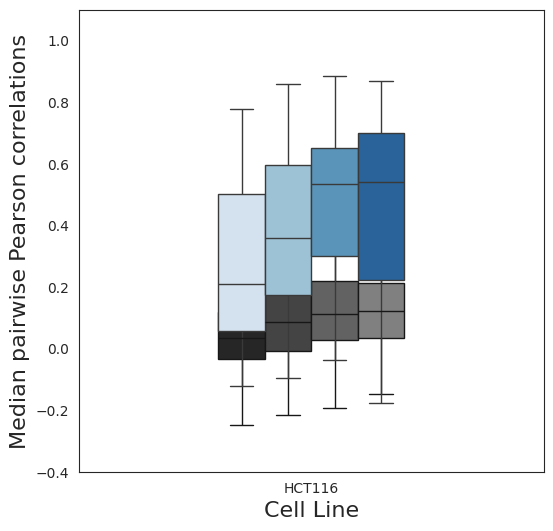

In [35]:
# Plot the data in a boxplot
corr_dist_all = corr_dist_all.reset_index(drop=True)
null_dist_all=null_dist_all.reset_index(drop=True)


fig, ax = plt.subplots(figsize=(6, 6))
sns.boxplot(data=null_dist_all, x='cell_line', y='corr', width=0.4, hue='Metadata_conc_step', palette='dark:grey', fill=True,  fliersize=1, showfliers=False, legend=False)
sns.boxplot(data=corr_dist_all, x='cell_line', y='corr', ax=ax, width=0.4, hue='Metadata_conc_step', palette='Blues', fill=True, fliersize=1, showfliers=False, legend=False)

ax.set_xlabel('Cell Line', fontsize=16)
ax.set_ylabel('Median pairwise Pearson correlations', fontsize=16)
ax.set_ylim(-0.4, 1.1)

# plt.title('Reproducibility - ' + data_type, fontsize=16)
plt.show()

# fig.savefig(
#         "3_Figure3/PercentReplicating/result-images/PercentReplicating_{}.{}".format(data_type, figformat), dpi=dpi, bbox_inches="tight"
#         )

In [36]:
pr

,data,cmpd_conc,perc_replicating
0,../1_FeaturesImages_none/SingleSlice/,1.0,42.307692
1,../1_FeaturesImages_none/SingleSlice/,2.0,50.000000
2,../1_FeaturesImages_none/SingleSlice/,3.0,66.666667
3,../1_FeaturesImages_none/SingleSlice/,4.0,63.043478
